# Alpaca Stock Data Source Review

This notebook documents the accumulation of real-time stock price data by connecting to the Alpaca Websocket.

## Objective
The goal is to accumulate real-time data of the stock tickers via Alpaca by connecting to its Websocket. We then want to save this stream of data for future reference across the project.

In [2]:
import os
import json
import asyncio
import websockets
from dotenv import load_dotenv
from datetime import datetime
import csv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import duckdb


# Load credentials
load_dotenv()
ALPACA_KEY_ID = os.getenv("ALPACA_KEY_ID")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

STOCKS = ["AAPL", "GOOGL", "AMZN", "MSFT", "NVDA"]
ALPACA_WS_URL = "wss://stream.data.alpaca.markets/v2/iex"

In [12]:
async def stream_alpaca():
    count = 0
    async with websockets.connect(ALPACA_WS_URL) as ws:
        # authentication
        auth_msg = {
            "action": "auth",
            "key": ALPACA_KEY_ID,
            "secret": ALPACA_SECRET_KEY
        }
        await ws.send(json.dumps(auth_msg))
        print("Auth message sent")
        response = await ws.recv()
        print("Auth response:", response)
        sub_msg = {
            "action": "subscribe",
            "trades": STOCKS
        }
        await ws.send(json.dumps(sub_msg))
        print("Subscribed to:", STOCKS)

        # stream data
        while count < 15:
            message = await ws.recv()
            data = json.loads(message)

            for entry in data:
                if entry.get("T") == "t":
                    timestamp = entry["t"]
                    symbol = entry["S"]
                    price = entry["p"]
                    quantity = entry["s"]
                    dt = datetime.fromisoformat(timestamp.replace("Z", "+00:00")).strftime("%F %T")

                    print(f"[{dt}] | {symbol} | {price} | ({quantity})")
                    count +=1


In [13]:
await stream_alpaca()

Auth message sent
Auth response: [{"T":"success","msg":"connected"}]
Subscribed to: ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'NVDA']
[2025-07-07 15:13:30] | AAPL | 212.29 | (100)
[2025-07-07 15:13:31] | AAPL | 212.295 | (100)
[2025-07-07 15:13:31] | MSFT | 497.78 | (3)
[2025-07-07 15:13:31] | GOOGL | 177.02 | (100)
[2025-07-07 15:13:33] | MSFT | 497.81 | (5)
[2025-07-07 15:13:33] | MSFT | 497.81 | (5)
[2025-07-07 15:13:34] | NVDA | 157.91 | (100)
[2025-07-07 15:13:35] | AAPL | 212.35 | (9)
[2025-07-07 15:13:35] | AAPL | 212.35 | (10)
[2025-07-07 15:13:35] | AAPL | 212.35 | (100)
[2025-07-07 15:13:35] | AAPL | 212.35 | (21)
[2025-07-07 15:13:35] | NVDA | 157.935 | (15)
[2025-07-07 15:13:35] | GOOGL | 177.04 | (150)
[2025-07-07 15:13:36] | AAPL | 212.365 | (94)
[2025-07-07 15:13:36] | AAPL | 212.365 | (6)


After getting authenticated and connecting to the Alpaca Websocket we are able to retrieve the trade data for the subscribed tickers. It is to be noted that we are only able to stream trades executed on the IEX exchange which accounts for about 2.5% of the total US equity volume.

In [15]:
logfile = (Path.cwd().parent.parent / "src" / "data" / "alpaca_stock_prices.csv").resolve()

async def stream_alpaca():
    async with websockets.connect(ALPACA_WS_URL) as ws:
        # authentication
        auth_msg = {
            "action": "auth",
            "key": ALPACA_KEY_ID,
            "secret": ALPACA_SECRET_KEY
        }
        await ws.send(json.dumps(auth_msg))
        await ws.recv()
        sub_msg = {
            "action": "subscribe",
            "trades": STOCKS
        }
        await ws.send(json.dumps(sub_msg))

        # stream data
        while True:
            try:
                message = await ws.recv()
                data = json.loads(message)

                for entry in data:
                    if entry.get("T") == "t":
                        timestamp = entry["t"]
                        symbol = entry["S"]
                        price = entry["p"]
                        quantity = entry["s"]
                        dt = datetime.fromisoformat(timestamp.replace("Z", "+00:00")).strftime("%F %T")

                        # write to a csv file
                        with open(logfile, mode="a", newline="") as f:
                            writer = csv.writer(f)
                            writer.writerow([dt, symbol, price, quantity])

            except websockets.exceptions.ConnectionClosed:
                await asyncio.sleep(5)
                return await stream_alpaca()


In [18]:
trades = pd.read_csv(logfile)
trades.sample(10)

,timestamp,symbol,price,quantity
15,2025-07-07 15:44:12,AMZN,224.050,100
142,2025-07-07 15:45:09,AAPL,211.800,100
513,2025-07-07 15:47:44,GOOGL,177.100,100
557,2025-07-07 15:47:59,AAPL,211.630,20
670,2025-07-07 15:48:41,MSFT,497.610,4
695,2025-07-07 15:48:55,AAPL,211.680,100
928,2025-07-07 15:50:53,AAPL,211.785,10
490,2025-07-07 15:47:36,GOOGL,177.150,30
819,2025-07-07 15:50:03,NVDA,158.000,1
101,2025-07-07 15:44:54,NVDA,157.830,221


Here we write the stream of data to a csv file. We keep track of the payload of each trade. This is a random sample of the data stream saved to a file by running the function stream_alpaca() for a few seconds. This data will be used later once we have gathered data from all sources.

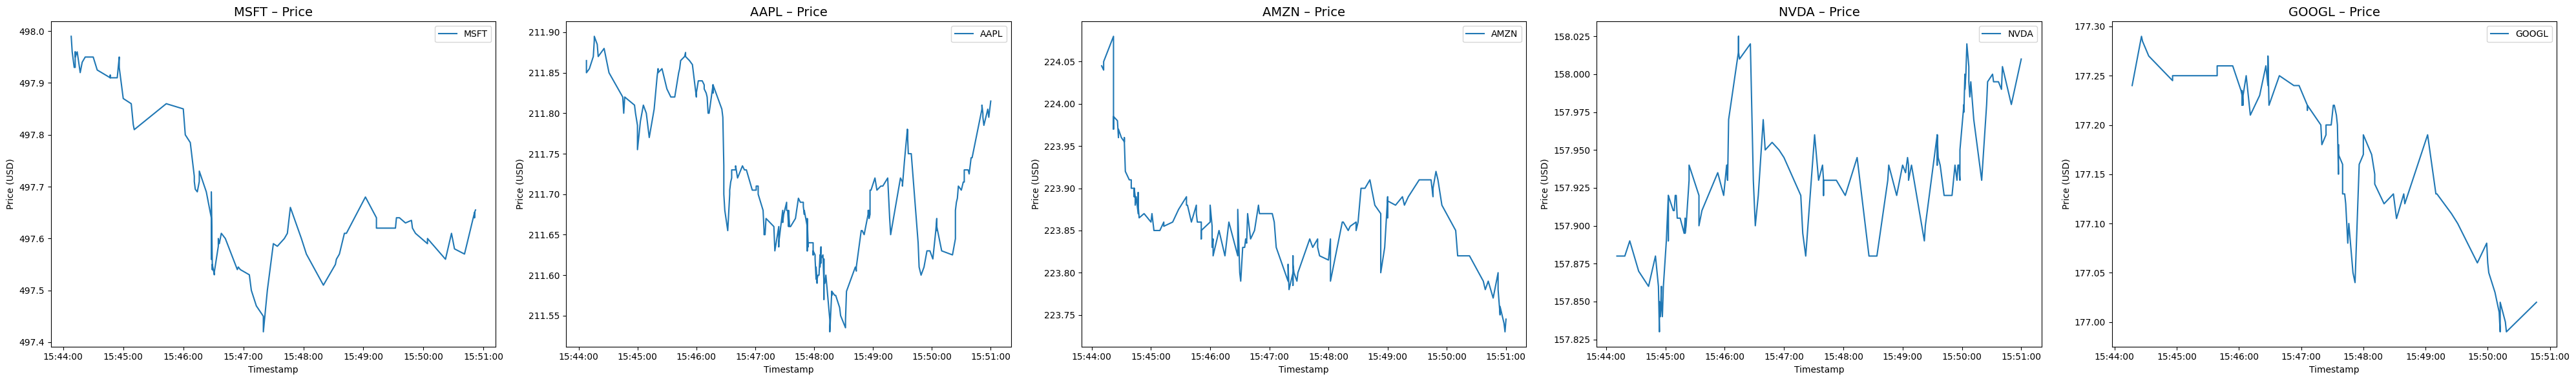

In [24]:
df = pd.read_csv(logfile, parse_dates=["timestamp"])
df.sort_values("timestamp", inplace=True)
tickers = df["symbol"].unique()

fig, axes = plt.subplots(1, len(tickers), figsize=(8 * len(tickers), 6), sharex=False)

for ax, symbol in zip(axes, tickers):
    data = df[df["symbol"] == symbol]
    ax.plot(data["timestamp"], data["price"], label=symbol)
    ax.set_title(f"{symbol} – Price", fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price (USD)")
    ax.legend()

plt.tight_layout()
plt.show()

We have now collected, saved and plotted a short stream of data successfully. The stream of data is not as dense as expected but is enough for the scope of the project.

## Saving to DuckDB

In [3]:
DB_PATH = (Path.cwd().parent.parent / "src" / "data" / "market_attention.duckdb").resolve()
con = duckdb.connect(DB_PATH)

async def stream_alpaca():
    async with websockets.connect(ALPACA_WS_URL) as ws:
        # ...
        # ...
        # ...
        while True:
            ticker, price, quantity, ts = None, None, None, None
            # ...
            # ...
            # ...
            con.execute("""
                INSERT INTO prices (ticker, price, quantity, timestamp)
                VALUES (?, ?, ?, ?)
                """, (ticker, float(price), float(quantity), ts))
con.close()

Here we switch to DuckDB from a CSV file, like this we can keep the data more well maintained in tables and use joins for complex  queries.